In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=f2fde48686d6b58d2fd8ec2600cac7a714c5e5ad56df47df1b60d638e63f761f
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [8]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **IMPORT LIBRARY**

In [9]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
print(tf.__version__)

2.17.1


In [10]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **IMPORT DATA**

In [11]:
base_dir = '/content/drive/MyDrive/224x224data'
full_path = '/content/drive/MyDrive/ship_classification1'

train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')

# **Count data and classes**

In [12]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [13]:
base_dir = '/content/drive/MyDrive/ship_classification1'
full_path = '/content/drive/MyDrive/224x224data'

# Define train_dir, validation_dir, and test_dir
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(folder_dir)] # Use folder_dir instead of train_dir
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))


num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 25
number of classes in validation folder : 25
number of classes in test folder : 25


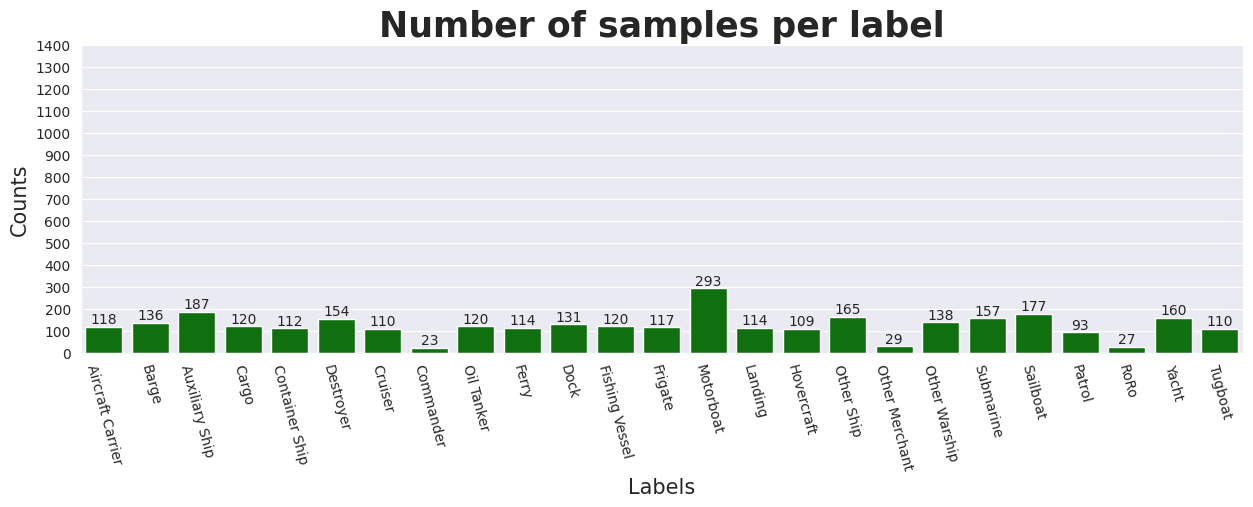

In [14]:
classes = [class_name for class_name in os.listdir(full_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(full_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

# **Convert data to a DataFrame**

In [15]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [16]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [17]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 2499
Number of samples in validation : 303
Number of samples test : 332


# **visualisasi image**

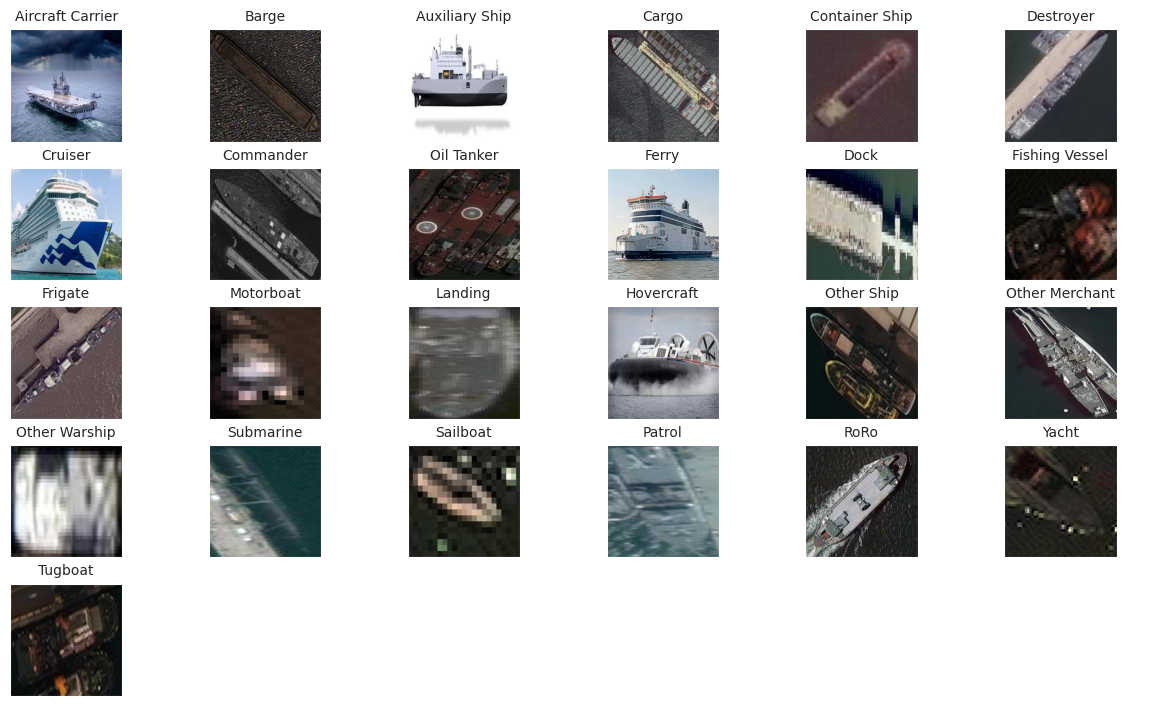

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [19]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,
    # Explicitly set num_classes to match the model's output shape
    num_classes=25
)

Found 2499 validated image filenames belonging to 25 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False,

    num_classes=25
)

Found 303 validated image filenames belonging to 25 classes.


In [21]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False,

    num_classes=25
)

Found 332 validated image filenames belonging to 25 classes.


# **Build Resnet50 model**

In [22]:
pre_trained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    classifier_activation='softmax',      # activation function
    pooling='avg'                         # type of pooling layer
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Freeze ResNet50 layers**

In [24]:
for i, layer in enumerate(pre_trained_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [25]:
# Freeze the layers up to conv4_block6_out
for layer in pre_trained_model.layers[:143]: # include the layer 142
    layer.trainable = False

# **Mendefinisikan model**

In [26]:
# Create the new model
x = pre_trained_model.output
# x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(25, activation='softmax')(x)

transfer_resnet50_model = tf.keras.models.Model(
    inputs=pre_trained_model.input,
    outputs=x
)

In [27]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,638,937 (90.18 MB)

 Trainable params: 15,027,225 (57.32 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

# **Compile Model**

In [28]:
transfer_resnet50_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Define the callbacks
# Model CheckPoint
checkpoint_cb = ModelCheckpoint(
    'my_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stoping
earlystop_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5,
    verbose=1,
    mode='min'
)

# Train the model
history = transfer_resnet50_model.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1128 - loss: 3.1061
Epoch 1: val_loss improved from inf to 3.30247, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 936s 11s/step - accuracy: 0.1129 - loss: 3.1047 - val_accuracy: 0.0462 - val_loss: 3.3025 - learning_rate: 1.0000e-04
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1689 - loss: 2.7410
Epoch 2: val_loss improved from 3.30247 to 2.91127, saving model to my_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 831s 10s/step - accuracy: 0.1690 - loss: 2.7408 - val_accuracy: 0.1221 - val_loss: 2.9113 - learning_rate: 1.0000e-04
Epoch 3/50


# **Plot the result of training**

In [60]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
45,0.555822,1.406316,0.438944,1.910012,9.999999e-07
46,0.549820,1.397990,0.435644,1.913981,9.999999e-07
47,0.562225,1.399693,0.435644,1.914627,9.999999e-07
48,0.560624,1.398175,0.432343,1.922121,9.999999e-07
49,0.541016,1.419602,0.438944,1.914095,9.999999e-07


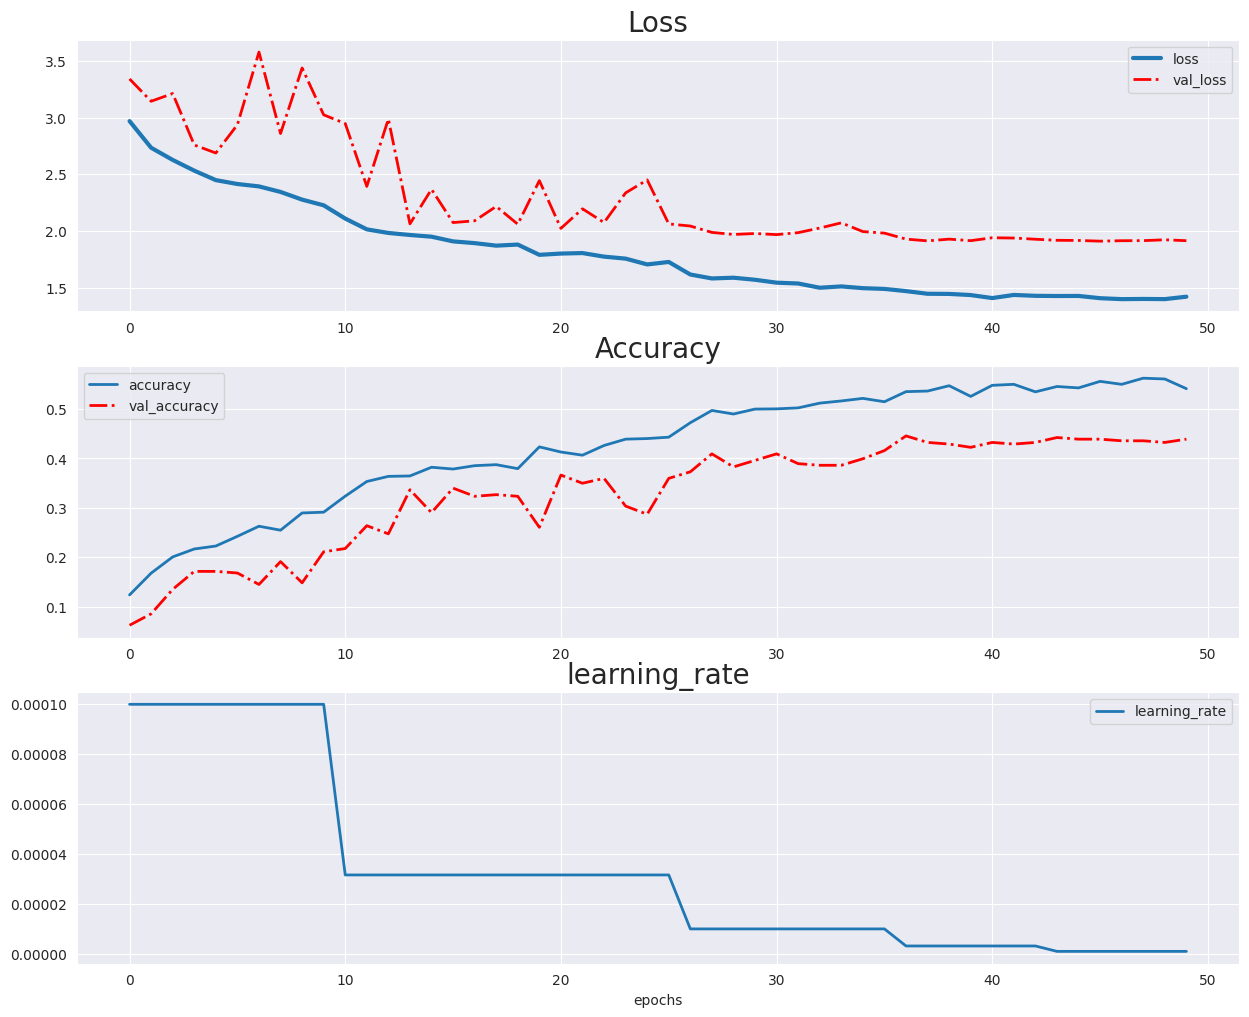

In [61]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [62]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Aircraft Carrier
1 : Auxiliary Ship
2 : Barge
3 : Cargo
4 : Commander
5 : Container Ship
6 : Cruiser
7 : Destroyer
8 : Dock
9 : Ferry
10 : Fishing Vessel
11 : Frigate
12 : Hovercraft
13 : Landing
14 : Motorboat
15 : Oil Tanker
16 : Other Merchant
17 : Other Ship
18 : Other Warship
19 : Patrol
20 : RoRo
21 : Sailboat
22 : Submarine
23 : Tugboat
24 : Yacht


In [63]:
predictions = transfer_resnet50_model.predict(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step


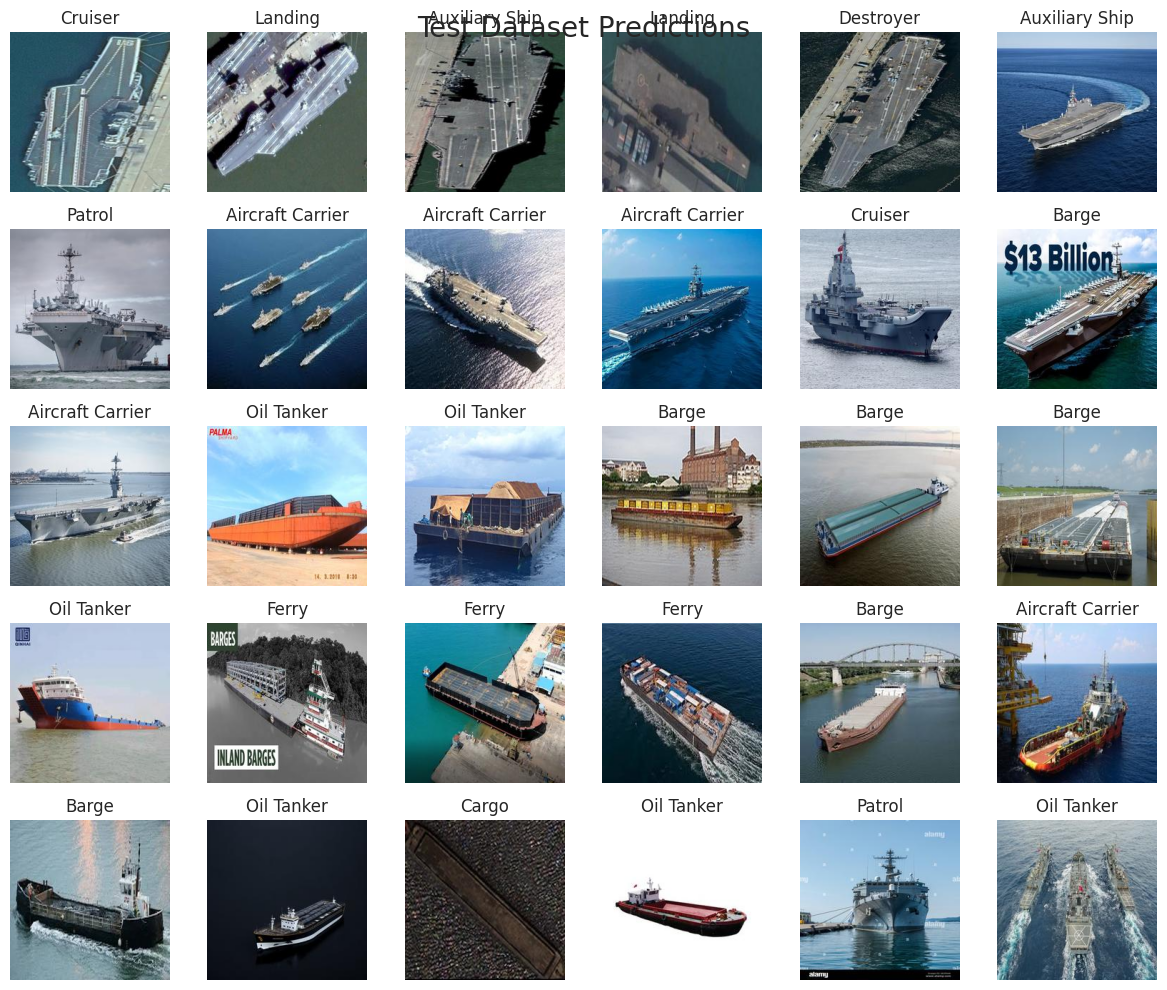

In [64]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [65]:
test_loss, test_accuracy = transfer_resnet50_model.evaluate(test_generator, batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3663 - loss: 1.9565


In [66]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     1.802526593208313
Test Accuracy: 0.4277108311653137 -> 42.77%


# **PLOT CONFUSION MATRIX**

In [67]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

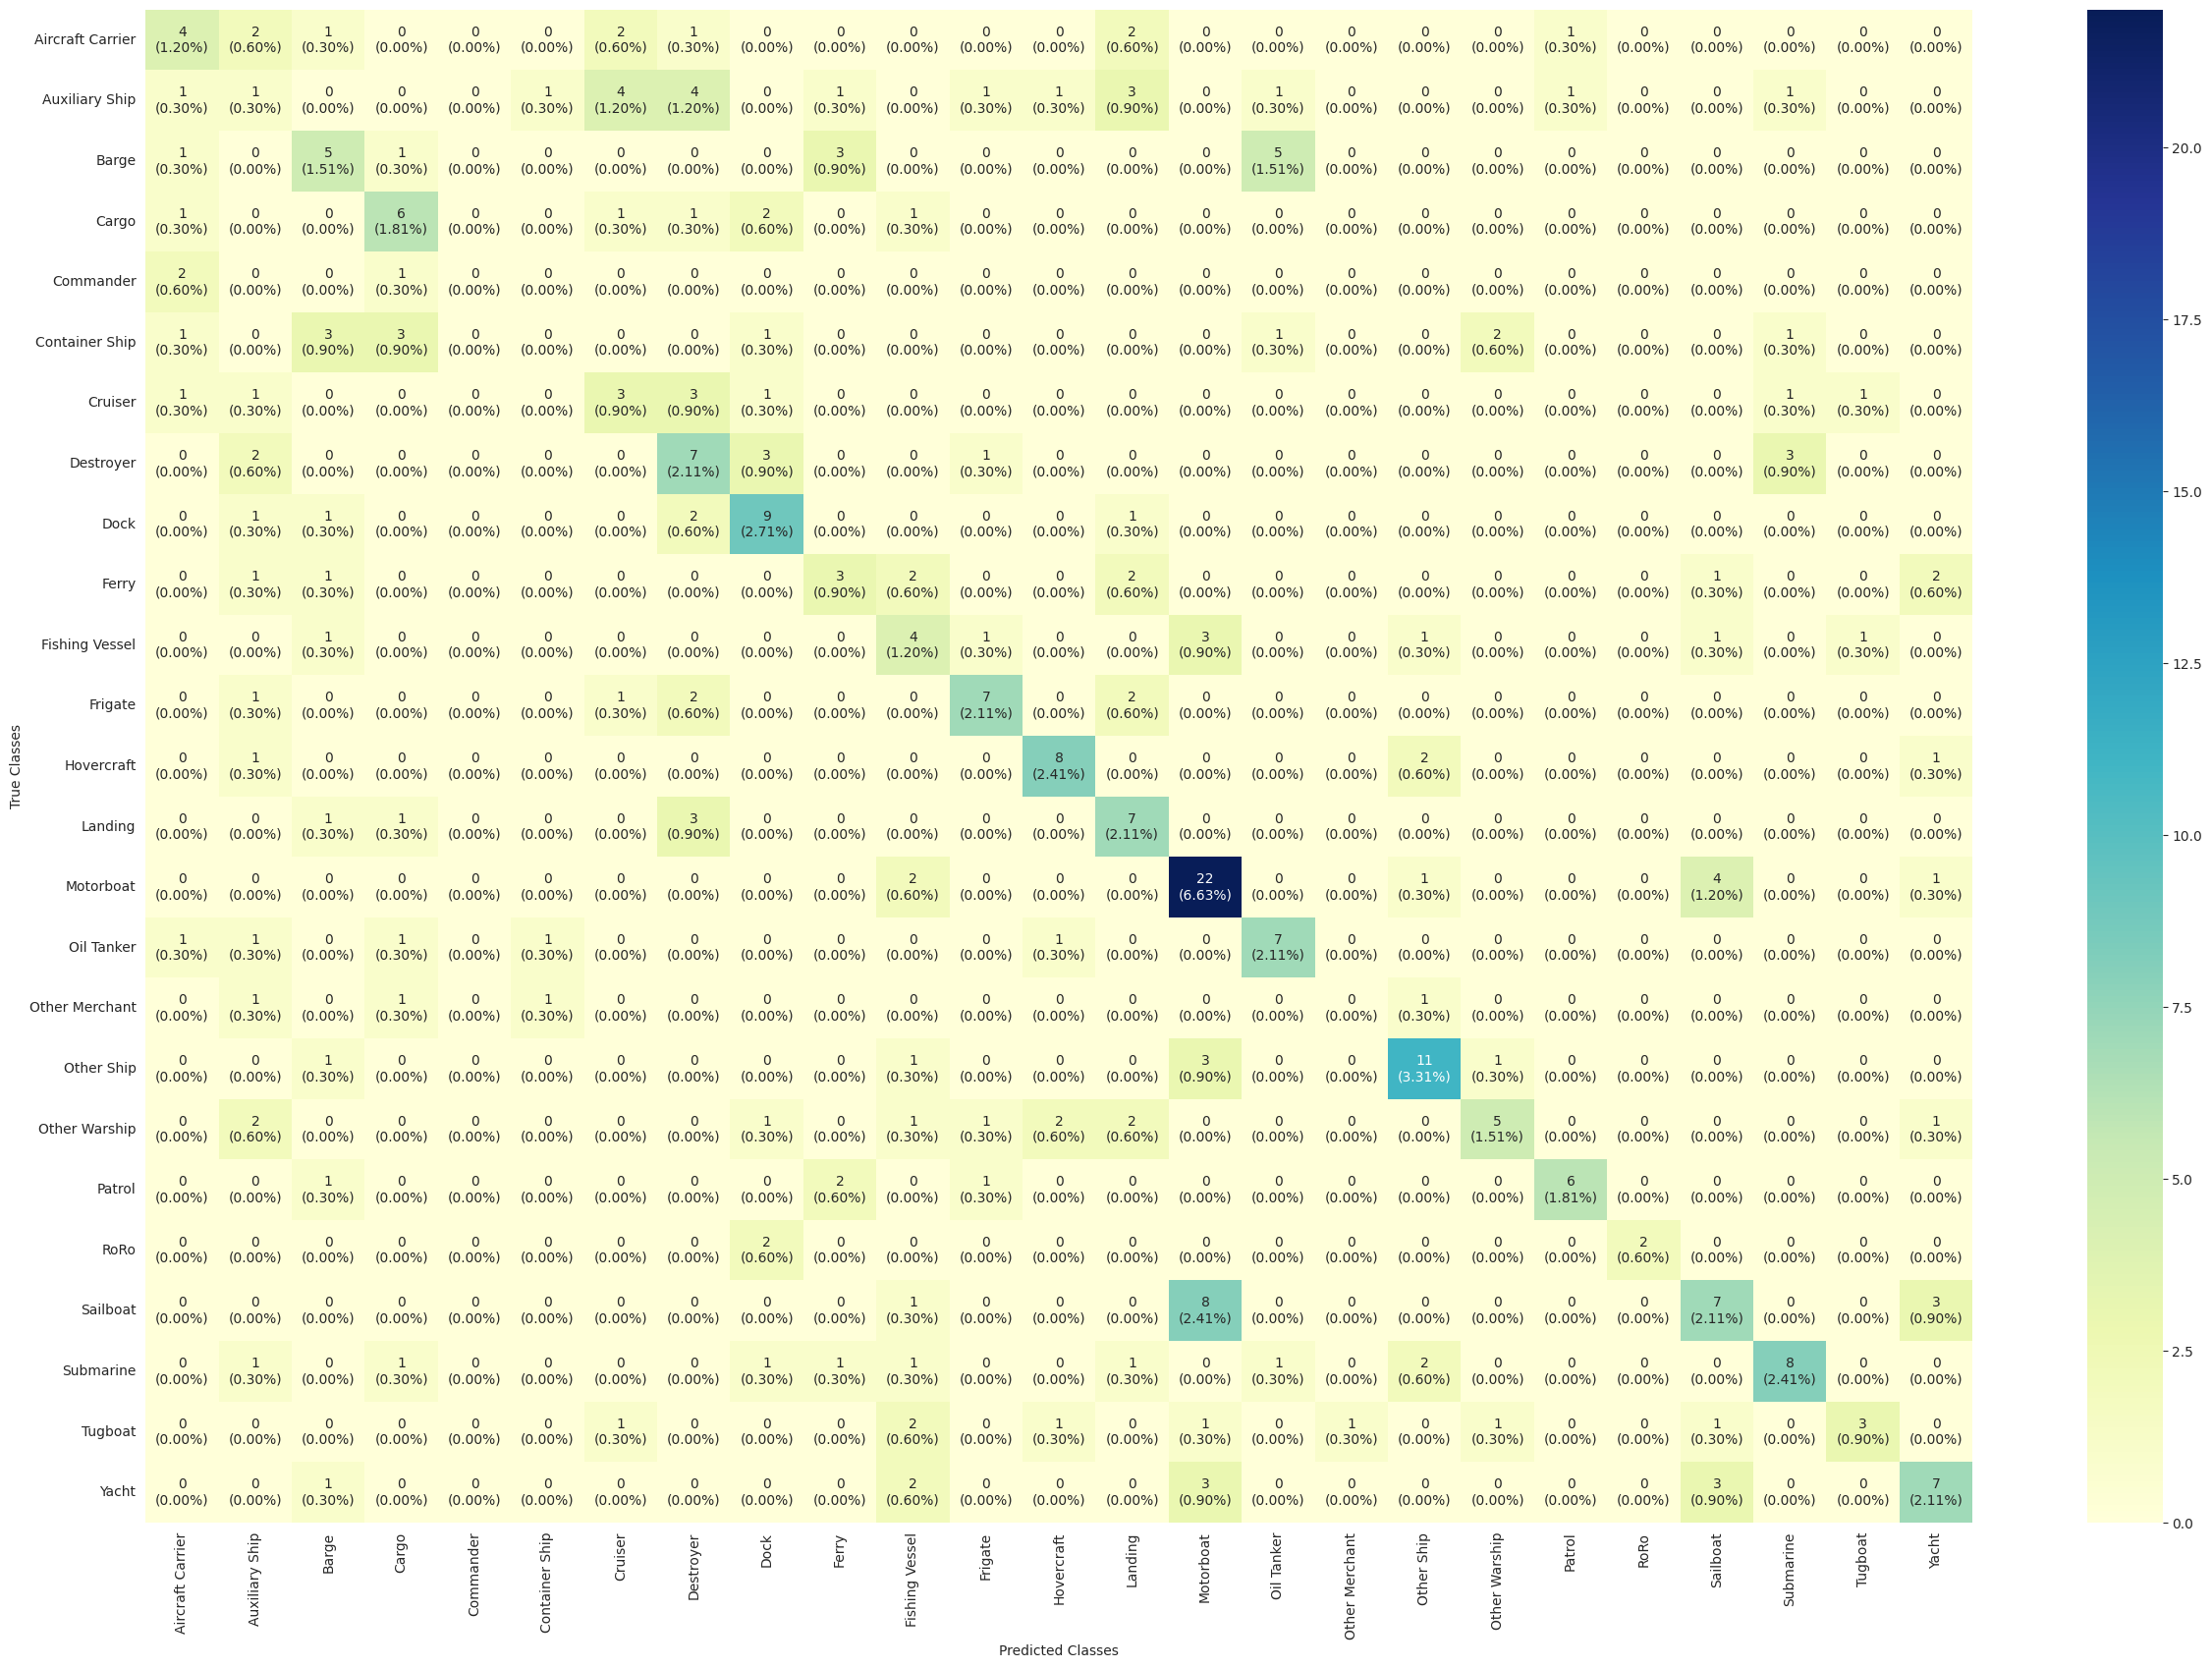

In [69]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
# Reshape to match the confusion matrix dimensions
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape) # Reshape to (25, 25)

plt.figure(figsize = (30, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [70]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

                  precision    recall  f1-score   support

Aircraft Carrier       0.33      0.31      0.32        13
  Auxiliary Ship       0.07      0.05      0.06        20
           Barge       0.31      0.33      0.32        15
           Cargo       0.40      0.50      0.44        12
       Commander       0.00      0.00      0.00         3
  Container Ship       0.00      0.00      0.00        12
         Cruiser       0.25      0.27      0.26        11
       Destroyer       0.30      0.44      0.36        16
            Dock       0.45      0.64      0.53        14
           Ferry       0.30      0.25      0.27        12
  Fishing Vessel       0.24      0.33      0.28        12
         Frigate       0.58      0.54      0.56        13
      Hovercraft       0.62      0.67      0.64        12
         Landing       0.35      0.58      0.44        12
       Motorboat       0.55      0.73      0.63        30
      Oil Tanker       0.47      0.58      0.52        12
  Other Merch

# **WRONG PREDICT**

In [71]:
y_true = np.array(y_true)
print(y_true.shape)

(332,)


In [72]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [73]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 332
Jumlah prediksi yang salah: 190
Persentase prediksi yang salah: 57.22891566265061%


In [74]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [78]:
fig, ax = plt.subplots(nrows=total_errors, ncols=1, figsize=(400, 400))

for idx, error in enumerate(y_true_errors):
    true_label = labels[error]
    predicted_label = labels[y_hat_errors[idx]]
    ax[idx].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
    img_path = os.path.join(test_dir, test_img[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(img)
    ax[idx].axis("off")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [83]:
transfer_resnet50_model.save("/content/drive/MyDrive/Colab Notebooks/UAP/transfer_resnet50_model.h5") # Changed 'model' to 'transfer_resnet50_model'